# 1.Loading the data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm


from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')

In [0]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 




## 3.1 Spliting CleanedText and Score

In [0]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)

x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]



x1,x_test,y1,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)
x_tr,x_cv,y_tr,y_cv=train_test_split(x1,y1,test_size=0.25,shuffle=False)

In [0]:
print(x1.shape,y1.shape)

(80000,) (80000,)


In [0]:
print(x_test.shape,y_test.shape)

(20000,) (20000,)


# 4.Bag of Words (BoW)

# 4.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)
x_cv_uni= bow.transform(x_cv)

### 4.1.1 Finding the optimal alpha

In [0]:
from sklearn.metrics import roc_auc_score
cv_err = []
test_err=[]
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
    clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
    clf.fit(x_tr_uni,y_tr)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(x_tr_uni, y_tr)
    predicted_y = calib_clf.predict_proba(x_cv_uni)
    probs = predicted_y[:, 1]
    cv_err.append(roc_auc_score(y_cv, probs))

### 4.1.2 finding the Roc_auc value on cv data using optimal alpha

0.9332475785624053
0.001


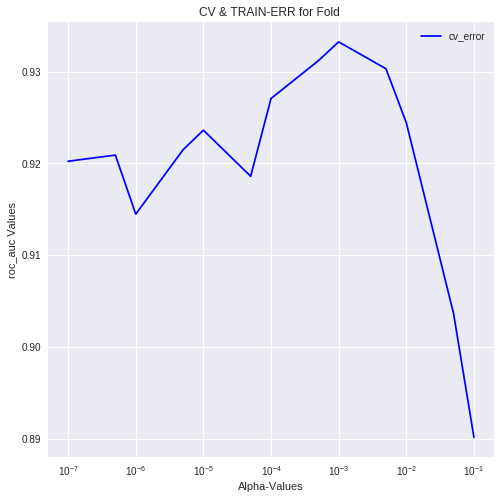

In [0]:
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_err,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('roc_auc Values')
plt.legend()
print(max(cv_err))
print(a_val[cv_err.index(max(cv_err))])

### 4.1.3 finding the Roc_auc value on Test data using optimal alpha

0.9409401786642803
Accuracy on test set: 90.770%
Precision on test set: 0.870
Recall on test set: 0.794
F1-Score on test set: 0.824


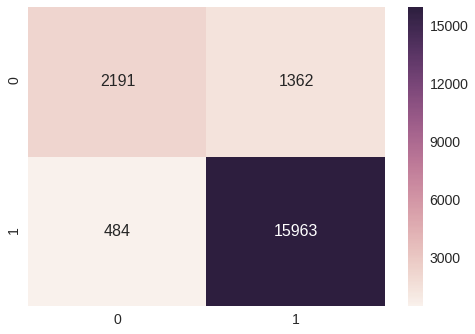

In [0]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(x_tr_1,y1)
predicted_y_Pro = calib_clf.predict_proba(x_test_uni)
y_pred= calib_clf.predict(x_test_uni)
probs = predicted_y_Pro[:, 1]
print(roc_auc_score(y_test, probs))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.2 Bi-Grams


In [0]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)
x_cv_bi= bi_gram.transform(x_cv)

### 4.2.1 Finding the optimal alpha

In [0]:
from sklearn.metrics import roc_auc_score
cv_err = []
test_err=[]
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
  clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
  clf.fit(x_tr_bi,y_tr)
  calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
  calib_clf.fit(x_tr_bi, y_tr)
  predicted_y = calib_clf.predict_proba(x_cv_bi)
  probs = predicted_y[:, 1]
  cv_err.append(roc_auc_score(y_cv, probs))

### 4.2.2 finding the Roc_auc value on cv data using optimal alpha

0.9425033262288682
0.001


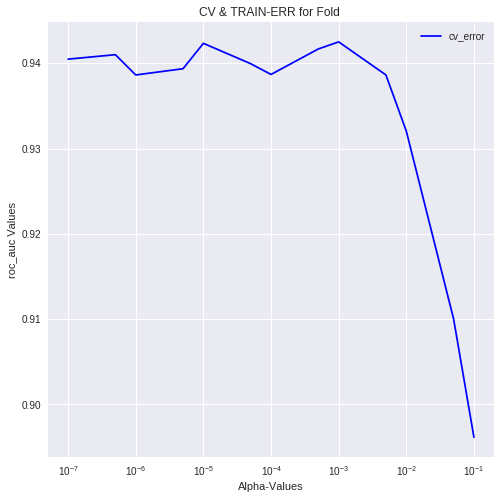

In [0]:
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_err,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('roc_auc Values')
plt.legend()
print(max(cv_err))
print(a_val[cv_err.index(max(cv_err))])

## 4.2.3 finding the Roc_auc value on Test data using optimal alpha

roc_auc on test set:0.9509698193045584
Accuracy on test set: 91.985%
Precision on test set: 0.887
Recall on test set: 0.825
F1-Score on test set: 0.851


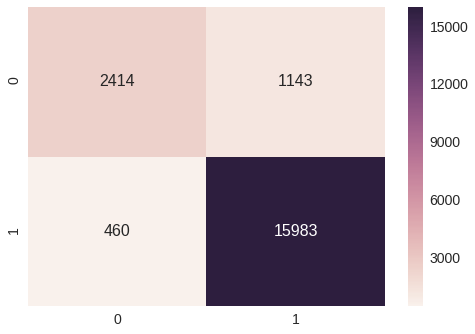

In [0]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(x_1_bi,y1)
predicted_y_Pro = calib_clf.predict_proba(x_test_bi)
y_pred= calib_clf.predict(x_test_bi)
probs = predicted_y_Pro[:, 1]
print("roc_auc on test set:{}".format(roc_auc_score(y_test, probs)))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 5 TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x1)
x_test_tfidf = tf_idf_vect.transform(x_test)

### 4.1.1 Finding the optimal alpha

In [0]:
from sklearn.metrics import roc_auc_score
cv_err = []
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
  clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
  clf.fit(x_tr_tfidf,y_tr)
  calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
  calib_clf.fit(x_tr_tfidf, y_tr)
  predicted_y = calib_clf.predict_proba(x_cv_tfidf)
  probs = predicted_y[:, 1]
  cv_err.append(roc_auc_score(y_cv, probs))

### 4.1.2 finding the accuracy in Test data using optimal C

0.956250975154884
1e-05


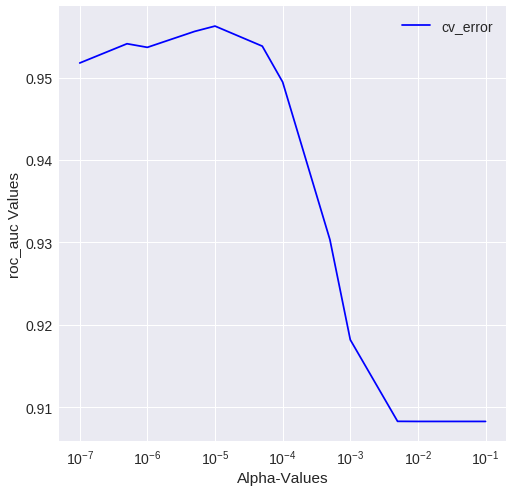

In [0]:
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_err,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('roc_auc Values')
plt.legend()
print(max(cv_err))
print(a_val[cv_err.index(max(cv_err))])

roc_auc on test set:0.961105089524155
Accuracy on test set: 92.835%
Precision on test set: 0.891
Recall on test set: 0.855
F1-Score on test set: 0.872


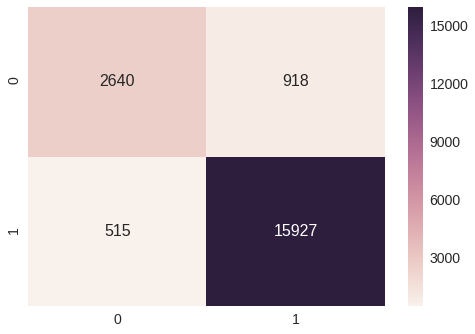

In [0]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.00001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(x_tr_tfidf,y1)
predicted_y_Pro = calib_clf.predict_proba(x_test_tfidf)
y_pred= calib_clf.predict(x_test_tfidf)
probs = predicted_y_Pro[:, 1]
print("roc_auc on test set:{}".format(roc_auc_score(y_test, probs)))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 6 Word2Vec

In [0]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())

i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
i=0
list_of_sent_cv=[]
for sent in x_cv:
    list_of_sent_cv.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9861
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'hard', 'ever', 'write', 'review', 'rice', 'good', 'live', 'hawaii', 'never', 'seen', 'caribbean', 'sale', 'store', 'came', 'across', 'search', 'amazon', 'glad', 'gave', 'think', 'youll', 'disappoint', 'ad', 'chop', 'chicken', 'suggest', 'also', 'small', 'onion', 'unbeliev', 'anoth', 'great', 'way', 'make', 'even', 'better', 'fresh']


# 7.Avg W2V

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

60000
50


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

20000
50


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

20000
50


In [0]:
x_test_av1=sent_vectors_test
x_tr_av1=sent_vectors
x_cv_av1=sent_vectors_cv

### 4.1.1 Finding the optimal alpha

In [0]:
from sklearn.metrics import roc_auc_score
cv_err = []
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
  clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
  calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
  calib_clf.fit(x_tr_av1, y_tr)
  predicted_y = calib_clf.predict_proba(x_cv_av1)
  probs = predicted_y[:, 1]
  cv_err.append(roc_auc_score(y_cv, probs))

### 4.1.2 finding the accuracy in Test data using optimal C

0.9015478475910293
0.001


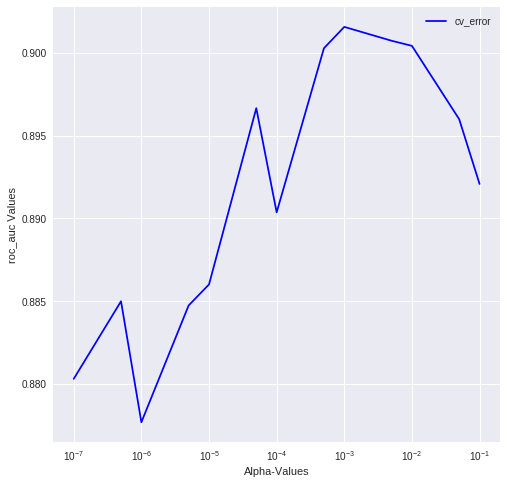

In [0]:
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_err,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('roc_auc Values')
plt.legend()
print(max(cv_err))
print(a_val[cv_err.index(max(cv_err))])

roc_auc on test set:0.9073420442478873
Accuracy on test set: 88.185%
Precision on test set: 0.826
Recall on test set: 0.732
F1-Score on test set: 0.765


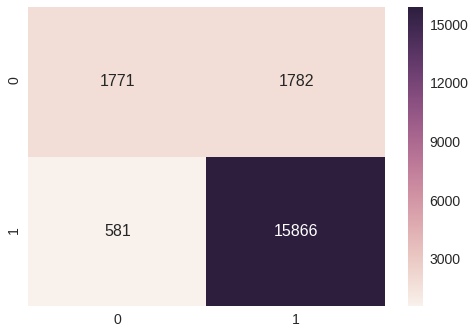

In [0]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(x_tr_av1,y_tr)
predicted_y_Pro = calib_clf.predict_proba(x_test_av1)
y_pred= calib_clf.predict(x_test_av1)
probs = predicted_y_Pro[:, 1]
print("roc_auc on test set:{}".format(roc_auc_score(y_test, probs)))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 8. TFIDF-W2V

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_tr)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [01:19<00:00, 755.34it/s]


In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:28<00:00, 689.75it/s]


In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:28<00:00, 701.88it/s]


In [0]:
x_test_tdfw2v=tfidf_sent_vectors_test
x_tr_tdfw2v=tfidf_sent_vectors
x_cv_tdfw2v=tfidf_sent_vectors_cv

### 4.1.1 Finding the optimal alpha

In [0]:
from sklearn.metrics import roc_auc_score
cv_err = []
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
  clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
  calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
  calib_clf.fit(x_tr_tdfw2v, y_tr)
  predicted_y = calib_clf.predict_proba(x_cv_tdfw2v)
  probs = predicted_y[:, 1]
  cv_err.append(roc_auc_score(y_cv, probs))

### 4.1.2 finding the accuracy in Test data using optimal C

0.9015478475910293
0.001


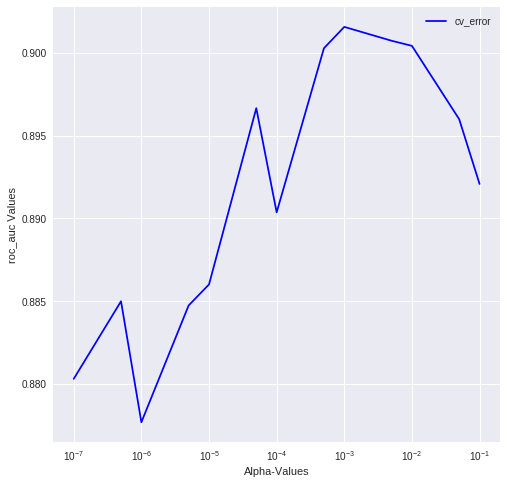

In [0]:
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_err,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('roc_auc Values')
plt.legend()
print(max(cv_err))
print(a_val[cv_err.index(max(cv_err))])

roc_auc on test set:0.8772559628330328
Accuracy on test set: 86.550%
Precision on test set: 0.799
Recall on test set: 0.684
F1-Score on test set: 0.719


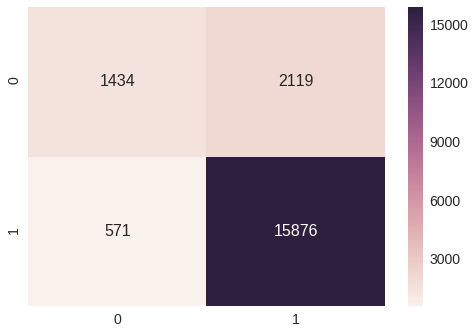

In [0]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(x_tr_tdfw2v,y_tr)
predicted_y_Pro = calib_clf.predict_proba(x_test_tdfw2v)
y_pred= calib_clf.predict(x_test_tdfw2v)
probs = predicted_y_Pro[:, 1]
print("roc_auc on test set:{}".format(roc_auc_score(y_test, probs)))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [11]:
svmResult = {

'Model': ['unigram', 'Bi-gram', 'Tf-IDF', 'Av-Word2Vec','Tf-IDF Word2vec'],
'alpha': ['0.001', '0.001', '0.00001', '0.001','0.001'],
'Test Roc Auc': ['0.9332475785624053','0.9425033262288682','0.956250975154884','0.9015478475910293','0.9015478475910293'],
'Train Roc Auc': ['0.9409401786642803','0.9509698193045584','0.961105089524155','0.9073420442478873','0.8772559628330328']
}
pd.DataFrame(svmResult)

,Model,alpha,Test Roc Auc,Train Roc Auc
0,unigram,0.001,0.9332475785624053,0.9409401786642803
1,Bi-gram,0.001,0.9425033262288682,0.9509698193045584
2,Tf-IDF,0.00001,0.956250975154884,0.961105089524155
3,Av-Word2Vec,0.001,0.9015478475910293,0.9073420442478873
4,Tf-IDF Word2vec,0.001,0.9015478475910293,0.8772559628330328
